# 02 — Econometrics Core: Linear Models & Diagnostics

This notebook builds the econometric baseline of the project.  
It examines how each asset responds to **systematic risk factors**, tests the validity of linear return–factor relationships, and measures whether these risk exposures remain stable over time. The goal is to establish a rigorous statistical foundation before moving into unit-root testing, volatility modelling, and forecasting.

### Objectives
- Construct a clean and aligned panel of excess returns and factor returns.  
- Estimate CAPM betas using the project’s market proxy.  
- Diagnose OLS assumptions: heteroskedasticity, serial correlation, and normality.  
- Compute rolling (time-varying) betas to study dynamic market sensitivity.  
- Fit FF5 + Momentum regressions using HAC-robust (Newey–West) inference.  
- Export an econometrics panel for Power BI and later modelling stages.

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/excess_returns_panel.csv` | Excess returns for IBEX, SP500, NASDAQ, EuroStoxx, VIX, EURUSD. |
| `/data/processed/factor_returns.csv` | Cleaned FF5 + Momentum factors + aligned SP500_excess. |
| `/data/processed/log_returns.csv` | Log returns used to compute SP500_excess. |
| `/data/raw/factors/*` | Raw Fama–French daily factor files (manual download). |

### Outputs
| File | Description |
|------|-------------|
| `/data/processed/capm_results.csv` | Alpha, beta, t-stats, R² for each CAPM regression. |
| `/data/processed/capm_diagnostics.csv` | White, BP, DW, BG, and JB diagnostic tests. |
| `/data/powerbi/rolling_betas_long.csv` | Long-format rolling betas for Power BI. |
| `/figures/02_Econometrics_Core_Linear_Models_&_Diagnostics/*.png` | Rolling-beta figures per asset. |
| `/data/powerbi/econometrics_panel.csv` | Final merged panel (returns + factors + rolling betas). |

### Tests Performed
| Test | Purpose |
|------|---------|
| **White / Breusch–Pagan** | Detect heteroskedasticity in residuals. |
| **Durbin–Watson / Breusch–Godfrey** | Detect autocorrelation in residuals. |
| **Jarque–Bera** | Evaluate non-normality and heavy tails. |
| **Rolling covariance windows** | Assess the stability of beta over time. |
| **HAC-robust OLS (Newey–West)** | Correct inference for heteroskedasticity + autocorrelation. |

### Notebook Structure
1. **Load and Align Data** import excess returns and factor tables; harmonize SP500_excess and join datasets.  
2. **CAPM Estimation** run OLS models for each asset using SP500_excess as the market factor.  
3. **Residual Diagnostics** apply White, BP, DW, BG and JB tests to evaluate model validity.  
4. **Rolling Betas** compute 252-day dynamic betas to capture changing exposures.  
5. **FF5 + Momentum Regression** estimate multifactor models with HAC-robust errors.  
6. **Power BI Exports** generate rolling betas and a unified econometric panel for dashboarding.

It identifies where simple models hold or fail, uncovers each asset’s true factor structure, and reveals the time-varying nature of market sensitivity. These insights are necessary to know for transitioning into the next step, the Time-Series Unit Tests notebook.


### Section 1 — Loading data and computing excess returns

This section prepares the foundational dataset for the entire econometric analysis. It loads the cleaned risk-free rate and the processed log-return series, aligns both on the same date index, and computes excess returns for every asset by subtracting the daily risk-free rate. The output is a  panel of excess returns that replaces raw returns in all subsequent regressions and factor models.

In [1]:
from pathlib import Path

# Project root
PROJECT_ROOT = Path("..")

# Standard data folders
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
POWERBI_DIR = DATA_DIR / "powerbi"

# Ensure folders exist
for folder in [RAW_DIR, PROCESSED_DIR, POWERBI_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

print("Data folders:")
print("RAW_DIR      :", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("POWERBI_DIR  :", POWERBI_DIR)


Data folders:
RAW_DIR      : ../data/raw
PROCESSED_DIR: ../data/processed
POWERBI_DIR  : ../data/powerbi


In [2]:
# N02 — Section 1: Load data for econometric modelling

import pandas as pd

# 1. Load excess returns (computed in N01)
excess_path = PROCESSED_DIR / "excess_returns_panel.csv"
df_excess = pd.read_csv(excess_path, parse_dates=["Date"]).set_index("Date")

print(" Excess returns loaded:")
display(df_excess.head())


# 2. Load factor dataset
factor_path = PROCESSED_DIR / "factor_returns.csv"
df_factors = pd.read_csv(factor_path, parse_dates=["Date"]).set_index("Date")

print("\n Factor returns loaded:")
display(df_factors.head())


# 2B. Resolve column conflicts (SP500_excess appears in both)
if "SP500_excess" in df_factors.columns:
    df_factors = df_factors.rename(columns={"SP500_excess": "SP500_excess_factor"})

print("\n Conflicts resolved. Columns now:")
print(df_factors.columns.tolist())

# 3. Merge excess returns + factor returns
df = df_excess.join(df_factors, how="inner")

print("\n Merged dataset for regression:")
display(df.head())
print("Shape:", df.shape)


 Excess returns loaded:


,EURUSD_excess,SP500_excess,IBEX35_excess,NASDAQ100_excess,EUROSTOXX50_excess,VIX_excess
Date,,,,,,
2000-01-04,-0.000204,-0.039303,-0.035568,-0.066838,-0.000204,0.109238
2000-01-05,-0.000204,0.001717,-0.031335,-0.011231,-0.000204,-0.022668
2000-01-06,-0.000203,0.000753,-0.000203,-0.048839,-0.000203,-0.026288
2000-01-07,-0.000202,0.026528,0.021588,0.054769,-0.000202,-0.169626
2000-01-10,-0.000202,0.010926,0.006163,0.051640,-0.000202,-0.000663



 Factor returns loaded:


,SP500_excess,MKT_RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,,
1963-07-01,NaN,-0.0067,0.0000,-0.0034,-0.0001,0.0016,-0.0023
1963-07-02,NaN,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0044
1963-07-03,NaN,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0038
1963-07-05,NaN,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0006
1963-07-08,NaN,-0.0063,0.0004,-0.0018,-0.0029,0.0014,-0.0045



 Conflicts resolved. Columns now:
['SP500_excess_factor', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']

 Merged dataset for regression:


,EURUSD_excess,SP500_excess,IBEX35_excess,NASDAQ100_excess,EUROSTOXX50_excess,VIX_excess,SP500_excess_factor,MKT_RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,,,,,,,,
2000-01-04,-0.000204,-0.039303,-0.035568,-0.066838,-0.000204,0.109238,-0.039299,-0.0406,0.0034,0.0207,0.0053,0.0136,-0.0191
2000-01-05,-0.000204,0.001717,-0.031335,-0.011231,-0.000204,-0.022668,0.001720,-0.0009,0.0036,-0.0005,0.0045,0.0115,-0.0049
2000-01-06,-0.000203,0.000753,-0.000203,-0.048839,-0.000203,-0.026288,0.000755,-0.0074,-0.0004,0.0124,0.0064,0.0121,-0.0149
2000-01-07,-0.000202,0.026528,0.021588,0.054769,-0.000202,-0.169626,0.026530,0.0321,-0.0089,-0.0157,-0.0083,-0.0100,0.0059
2000-01-10,-0.000202,0.010926,0.006163,0.051640,-0.000202,-0.000663,0.010928,0.0175,0.0043,-0.0135,-0.0220,-0.0024,0.0201


Shape: (6275, 13)


### Section 2 — CAPM estimation using OLS

This section implements the Capital Asset Pricing Model (CAPM) for each asset in the excess-returns panel to quantify its exposure to broad market risk. Using the S&P 500 excess return as the market factor, the notebook estimates the linear model:

$$
R_{i,t} = \alpha_i + \beta_i R_{m,t} + \varepsilon_{i,t}
$$

The beta coefficient answers the question: “How much does this asset move when the market moves?”

- If **β = 1**, the asset behaves like the market.  
- If **β > 1**, the asset is more volatile and amplifies market swings.  
- If **β < 1**, it is more defensive and less sensitive to systematic shocks.  
- If **β < 0**, the asset moves opposite to the market (hedge behaviour).

The alpha parameter measures whether the asset earns more or less than what its market exposure would justify. A statistically significant alpha would indicate persistent over or under performance.

In [3]:
# N02 — Section 2: CAPM estimation using OLS
import statsmodels.api as sm

# 1. Load excess returns panel computed in Section 1
excess_path = PROCESSED_DIR / "excess_returns_panel.csv"
df = pd.read_csv(excess_path, parse_dates=["Date"]).set_index("Date")

print("excess_returns_panel.csv loaded:")
display(df.head())

# 2. Define market factor (SP500 excess returns)
market_col = "SP500_excess"

if market_col not in df.columns:
    raise ValueError(f"Market column '{market_col}' not found in df.columns")

asset_cols = [col for col in df.columns if col != market_col]

print("\nAssets included for CAPM estimation:")
print(asset_cols)

# 3. Run OLS regression for each asset
results = []

for asset in asset_cols:
    y = df[asset]
    X = sm.add_constant(df[[market_col]])
    
    model = sm.OLS(y, X).fit()
    
    results.append({
        "Asset": asset.replace("_excess", ""),
        "Alpha": model.params["const"],
        "Beta": model.params[market_col],
        "Alpha_t": model.tvalues["const"],
        "Beta_t": model.tvalues[market_col],
        "Alpha_p": model.pvalues["const"],
        "Beta_p": model.pvalues[market_col],
        "R2": model.rsquared,
        "Observations": model.nobs
    })

capm_table = pd.DataFrame(results)

print("\nCAPM results table:")
display(capm_table)

# 4. Export CAPM table for reporting / Power BI
capm_path = PROCESSED_DIR / "capm_results.csv"
capm_table.to_csv(capm_path, index=False)

print(f" CAPM results exported to: {capm_path}")


excess_returns_panel.csv loaded:


,EURUSD_excess,SP500_excess,IBEX35_excess,NASDAQ100_excess,EUROSTOXX50_excess,VIX_excess
Date,,,,,,
2000-01-04,-0.000204,-0.039303,-0.035568,-0.066838,-0.000204,0.109238
2000-01-05,-0.000204,0.001717,-0.031335,-0.011231,-0.000204,-0.022668
2000-01-06,-0.000203,0.000753,-0.000203,-0.048839,-0.000203,-0.026288
2000-01-07,-0.000202,0.026528,0.021588,0.054769,-0.000202,-0.169626
2000-01-10,-0.000202,0.010926,0.006163,0.051640,-0.000202,-0.000663



Assets included for CAPM estimation:
['EURUSD_excess', 'IBEX35_excess', 'NASDAQ100_excess', 'EUROSTOXX50_excess', 'VIX_excess']

CAPM results table:


,Asset,Alpha,Beta,Alpha_t,Beta_t,Alpha_p,Beta_p,R2,Observations
0,EURUSD,-0.000079,0.058915,-0.963954,8.753883,0.335106,2.615716e-18,0.012068,6275.0
1,IBEX35,-0.000165,0.594761,-1.087690,47.625236,0.276774,0.000000e+00,0.265557,6275.0
2,NASDAQ100,0.000018,1.223488,0.163079,134.166446,0.870461,0.000000e+00,0.741571,6275.0
3,EUROSTOXX50,-0.000133,0.495699,-1.069104,48.226388,0.285064,0.000000e+00,0.270478,6275.0
4,VIX,0.000534,-4.285252,0.874925,-85.242972,0.381648,0.000000e+00,0.536684,6275.0


 CAPM results exported to: ../data/processed/capm_results.csv


#### Key insights

- **Nasdaq 100** exhibits the strongest exposure to market risk (β ≈ 1.22) and the highest explanatory power (R² ≈ 0.74). This indicates that approximately 74% of its excess return variability is explained by movements in the market factor alone, reflecting its growth-oriented composition and high sensitivity to systematic equity risk.

- **European equity indices (IBEX 35 and EuroStoxx 50)** display moderate market betas (β ≈ 0.5–0.6) and substantially lower R² values (≈ 0.26–0.27). This suggests that while they co-move with global equity markets, a large fraction of their return dynamics is driven by regional, sectoral, or macroeconomic factors not captured by a single global market proxy.

- **EUR/USD** shows a near-zero beta and negligible explanatory power (R² ≈ 0.01), indicating that US equity market risk has virtually no ability to explain currency excess returns. This is consistent with FX dynamics being primarily driven by interest rate differentials, monetary policy expectations, and macroeconomic fundamentals rather than equity risk premia.

- **VIX** displays a large and highly significant negative beta (β ≈ −4.3) with relatively high explanatory power (R² ≈ 0.54). This confirms its role as a systemic hedge: volatility increases sharply during equity market downturns, producing a strong inverse relationship with market excess returns.

- Alpha estimates are not statistically significant across all assets, implying no evidence of persistent over- or under-performance once exposure to market risk is accounted for. This supports the CAPM as an appropriate baseline model for mean excess returns and provides a clean benchmark against which the incremental explanatory power of multifactor models (FF5 + Momentum) can be evaluated.

### Section 3 — Residual diagnostics for CAPM models

This section assesses whether the CAPM regressions satisfy the classical linear model assumptions. For each asset, we apply tests for heteroskedasticity, autocorrelation, and normality using the regression residuals.

#### 1. Heteroskedasticity (White & Breusch–Pagan)
The White test strongly rejects homoskedasticity for *all* assets (p-values near zero).  
This means return volatility changes over time—a classic feature of financial data.

Breusch–Pagan confirms the same pattern for VIX (p ≈ 3e−16), and although some assets do not reject under BP, the White test is more general and clearly indicates that variance is far from constant.

This is direct evidence of volatility clustering, one of the main motivations for using GARCH-type models later in the project.

#### 2. Autocorrelation (Durbin–Watson & Breusch–Godfrey)
- EURUSD, IBEX35, EUROSTOXX50, and VIX all exhibit significant autocorrelation (BG p-values essentially zero).
- NASDAQ100 is the only asset without meaningful serial correlation (BG p ≈ 0.61).

Residual autocorrelation means that CAPM leaves a predictable structure in returns, violating OLS assumptions and reducing the reliability of t-statistics unless corrected.

This motivates the later use of HAC-robust errors in the FF5+MOM regressions.

#### 3. Normality (Jarque–Bera)
All JB p-values are 0.0, meaning every asset strongly violates normality.

Residuals display:
- heavy tails (kurtosis >> 3),
- skewness
- extreme values typical of financial series.

This aligns with stylised facts: asset returns are not normally distributed and exhibit fat-tailed behaviour, especially for VIX and high-volatility indices.

### Implications

The diagnostics show that:
- CAPM is too simple to capture the true dynamics of these assets.
- Residuals are affected by heteroskedasticity, autocorrelation, and heavy tails.
- Naive OLS inference is unreliable under these conditions.

As a result, the notebook moves toward:
- **HAC (Newey–West) regression** for robust inference,  
- **multifactor models** (FF5 + Momentum) to improve explanatory power, and  
- **time-varying beta analysis** to capture dynamic risk exposures.

These diagnostics justify the transition from a static CAPM to richer econometric models in the rest of the project.


In [4]:
# N02 — Section 3: Residual Diagnostics for CAPM models
import numpy as np
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson

# 1. Load the excess returns panel (needed to rebuild regressions)
excess_path = PROCESSED_DIR / "excess_returns_panel.csv"
df = pd.read_csv(excess_path, parse_dates=["Date"]).set_index("Date")

market_col = "SP500_excess"
asset_cols = [col for col in df.columns if col != market_col]

diagnostics = []

# 2. Perform residual diagnostics for each CAPM regression
for asset in asset_cols:

    y = df[asset]
    X = sm.add_constant(df[[market_col]])
    model = sm.OLS(y, X).fit()

    residuals = model.resid

    # ------ Heteroscedasticity tests ------
    white_test = het_white(residuals, model.model.exog)
    white_stat, white_p = white_test[0], white_test[1]

    bp_test = het_breuschpagan(residuals, model.model.exog)
    bp_stat, bp_p = bp_test[0], bp_test[1]

    # ------ Autocorrelation tests ------
    dw_stat = durbin_watson(residuals)

    bg_test = acorr_breusch_godfrey(model, nlags=1)
    bg_stat, bg_p = bg_test[0], bg_test[1]

    # ------ Normality ------
    jb_stat, jb_p, _, _ = jarque_bera(residuals)

    diagnostics.append({
        "Asset": asset.replace("_excess", ""),
        "White_Stat": white_stat,
        "White_p": white_p,
        "BP_Stat": bp_stat,
        "BP_p": bp_p,
        "DW_Stat": dw_stat,
        "BG_Stat": bg_stat,
        "BG_p": bg_p,
        "JB_Stat": jb_stat,
        "JB_p": jb_p
    })


diagnostics_table = pd.DataFrame(diagnostics)

print("CAPM residual diagnostics:")
display(diagnostics_table)

# 3. Export diagnostics table
diag_path = PROCESSED_DIR / "capm_diagnostics.csv"
diagnostics_table.to_csv(diag_path, index=False)

print(f"✓ Residual diagnostics exported to: {diag_path}")


CAPM residual diagnostics:


,Asset,White_Stat,White_p,BP_Stat,BP_p,DW_Stat,BG_Stat,BG_p,JB_Stat,JB_p
0,EURUSD,45.158829,1.562734e-10,1.031345,3.098431e-01,2.400782,251.847115,1.027443e-56,3.505731e+06,0.0
1,IBEX35,452.332603,5.987193e-99,0.569366,4.505112e-01,2.246326,94.305314,2.704234e-22,1.005387e+04,0.0
2,NASDAQ100,217.990286,4.613291e-48,0.051406,8.206341e-01,2.058042,0.255461,6.132561e-01,5.483599e+04,0.0
3,EUROSTOXX50,653.213848,1.433557e-142,0.752827,3.855828e-01,2.312658,150.506109,1.343809e-34,1.585890e+04,0.0
4,VIX,627.215219,6.337904e-137,66.693983,3.171016e-16,2.173841,45.560677,1.479828e-11,2.352752e+04,0.0


✓ Residual diagnostics exported to: ../data/processed/capm_diagnostics.csv


### Section 4 — Rolling Betas (Time-Varying CAPM Sensitivity)

This section extends the linear CAPM analysis by allowing each asset’s beta to evolve over time instead of assuming a fixed, constant exposure to market risk. Using the CAPM specification:

$$
R_{i,t} = \alpha_i + \beta_{i,t} R_{m,t} + \varepsilon_{i,t},
$$

we compute a rolling beta for every asset using a 252-day window (≈ one year).  
Before estimating the rolling coefficients, the returns and factor series are aligned on their common calendar and early flat segments are removed so that the rolling window always uses meaningful, non-constant data. For each day, the model is re-estimated using only past information, producing a full time series of \(\beta_{i,t}\).

This delivers a dynamic measure of market sensitivity that adjusts to structural breaks, volatility regimes, and macroeconomic cycles, offering a much richer view than the static CAPM.

### Key insights from the rolling betas

• **IBEX 35 and EuroStoxx 50** show a clear decline in market beta compared with their long-run CAPM estimates, reflecting partial decoupling from US risk after the financial crisis and the post-COVID recovery phase.  
• **NASDAQ 100** maintains a consistently high beta (≈1.3–1.4), confirming that tech stocks amplify market movements both upward and downward.  
• **VIX** keeps an extremely negative beta (around −8), illustrating its role as a natural hedge during spikes in global uncertainty.  
• **EUR/USD** remains close to a zero beta throughout the entire sample, confirming that FX returns are largely orthogonal to US equity risk at daily frequency.

These rolling betas are exported in both wide and long formats for integration into the Power BI dashboard and serve as a bridge toward the later volatility-based models (GARCH/EGARCH).


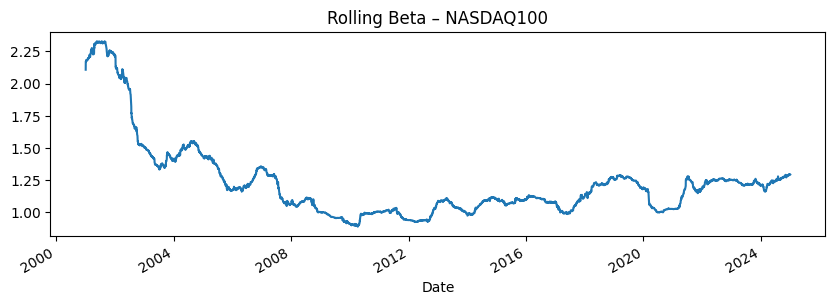

In [5]:
# 04 — Rolling Betas (Time-Varying CAPM Sensitivity)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
DATA = Path("..") / "data"
PROCESSED = DATA / "processed"
POWERBI = DATA / "powerbi"
POWERBI.mkdir(parents=True, exist_ok=True)

# 1. Load and align excess returns + factors
df = pd.read_csv(PROCESSED / "excess_returns_panel.csv",
                 parse_dates=["Date"]).set_index("Date")

factors = pd.read_csv(PROCESSED / "factor_returns.csv",
                      parse_dates=["Date"]).set_index("Date")

# Align on valid dates (inner join ensures shared time span)
df = df.join(factors[["MKT_RF"]], how="inner")

# Select assets for rolling betas
assets = [c for c in df.columns if c.endswith("_excess")]
market_col = "MKT_RF"

# Rolling window (≈ 1 year)
WINDOW = 252

# 2. Compute rolling beta for a single asset
def compute_rolling_beta(asset_series, market_series, window):
    cov = asset_series.rolling(window).cov(market_series).dropna()
    var_mkt = market_series.rolling(window).var().reindex(cov.index)
    return cov / var_mkt

# 3. Rolling betas for all assets
rolling_betas = {}

for asset in assets:
    rb = compute_rolling_beta(df[asset], df[market_col], WINDOW)
    rolling_betas[asset.replace("_excess", "")] = rb

rolling_betas_df = pd.DataFrame(rolling_betas)

# Example plot (only one shown to keep the notebook clean)
example_asset = "NASDAQ100_excess"
plt.figure(figsize=(10, 3))
rolling_betas_df[example_asset.replace("_excess","")].plot(
    title=f"Rolling Beta – {example_asset.replace('_excess','')}"
)
plt.show()

# 4. Export (wide + long formats)
rolling_wide_path = PROCESSED / "rolling_betas_wide.csv"
rolling_betas_df.to_csv(rolling_wide_path)

rolling_long = (
    rolling_betas_df
    .reset_index()
    .melt(id_vars="Date", var_name="Asset", value_name="Beta")
)
rolling_long_path = POWERBI / "rolling_betas_long.csv"
rolling_long.to_csv(rolling_long_path, index=False)


### Conclusions

This section demonstrates that market exposure is not a static characteristic of financial assets but a dynamic quantity that evolves over time, the results show that equity indices exhibit substantial time variation in their sensitivity to market movements. These findings have important methodological implications, the presence of time-varying betas implies that static CAPM estimates represent, at best, long-run averages that may be misleading in periods of market stress or structural change. Consequently, risk attribution, portfolio construction, and performance evaluation based on constant betas can underestimate true exposure during critical regimes.

## Section 5 — Building and Using the Factor Dataset 

This section constructs a fully aligned factor dataset from the Fama–French 5 Factors, the Momentum factor, and the project’s own SP500 excess return, and then uses this unified panel to estimate the full FF5 + MOM model with HAC-robust inference. This step forms the core of the linear factor modelling framework developed in this notebook.

### 5.1 Constructing `factor_returns.csv` (FF5 + MOM + SP500 Excess)

The raw Fama–French files require extensive preprocessing before being usable in daily regressions. The notebook imports the FF5 and MOM datasets, removes header noise, converts integer dates into proper `datetime` objects, filters out non-numeric rows, and rescales all factor values from percentages to decimals. Once cleaned, the two files are merged on their common calendar, producing a unified factor panel containing:

- **MKT_RF** (market excess return)  
- **SMB** (size)  
- **HML** (value)  
- **RMW** (profitability)  
- **CMA** (investment)  
- **MOM** (momentum)  
- **RF** (risk-free rate)

To ensure internal consistency with the rest of the project, the script loads the `log_returns.csv` file and computes an SP500 excess-return series that matches the exact returns used elsewhere in the analysis:

$$
\text{SP500\_excess}_t = r^{\text{SPX}}_t - RF_t.
$$

The resulting factor table — combining FF5, Momentum, and SP500 excess returns — is exported as  
`/data/processed/factor_returns.csv`, which becomes the master input for all multifactor regressions.

### 5.2 Loading and Aligning Excess Returns and Factor Data

The next step loads:

- the excess-returns panel created in Section 1, and  
- the factor_returns.csv produced above.

Since both datasets include a variable named `SP500_excess`, the factor version is automatically renamed (`SP500_excess_factor`) to avoid name collisions. Both tables are then merged using an inner join, ensuring date alignment and preventing missing-data distortions in the regressions.

The resulting dataframe `df` is the final, synchronized econometric panel that feeds the multifactor model.

### 5.3 FF5 + Momentum Regression with HAC-Robust Errors

For each excess-return series:

1. A clean design matrix is built, consisting of a constant and the six factors  
   (`MKT_RF`, `SMB`, `HML`, `RMW`, `CMA`, `MOM`).

2. An OLS model is fitted with heteroskedasticity- and autocorrelation-consistent (HAC) standard errors, using a Newey–West correction with five lags.  

3. A compact summary table of coefficients, t-statistics, and p-values is printed for inspection.

4. A complete coefficient table is exported as a dedicated CSV file for reporting or Power BI integration.

This multifactor specification provides a richer, more realistic decomposition of systematic risk than the CAPM, capturing exposures not only to the market factor but also to size, value, profitability, investment style, and momentum.


In [6]:
# Build factor_returns.csv from manually placed FF5 + MOM files

import pandas as pd
import numpy as np
from pathlib import Path

RAW_FACTORS = Path("..") / "data" / "raw" / "factors"
PROCESSED = Path("..") / "data" / "processed"

# 1. Load FF5 data
ff5 = pd.read_csv(RAW_FACTORS / "ff5_daily.csv", skiprows=3)

# Rename first column (Date)
ff5 = ff5.rename(columns={ff5.columns[0]: "Date"})

# Keep only rows where Date is numeric (avoid headers/footers)
ff5 = ff5[ff5["Date"].astype(str).str.isdigit()]

# Convert Date
ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m%d")
ff5 = ff5.set_index("Date")

# Convert percent → decimal
ff5 = ff5 / 100

print(" FF5 loaded:")
display(ff5.head())

# 2. Load MOM factor
mom = pd.read_csv(RAW_FACTORS / "mom_daily.csv", skiprows=13)
mom = mom.rename(columns={mom.columns[0]: "Date"})
mom = mom[mom["Date"].astype(str).str.isdigit()]
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m%d")
mom = mom.set_index("Date") / 100

print("Momentum loaded:")
display(mom.head())

# 3. Merge FF5 + MOM
factors = ff5.join(mom, how="inner")

# Rename columns for consistency
factors = factors.rename(columns={"Mkt-RF": "MKT_RF", "Mom": "MOM"})

print(" Factors merged:")
display(factors.head())

# 4. Compute SP500_excess using your log returns
logr = pd.read_csv(PROCESSED / "log_returns.csv", parse_dates=["Date"]).set_index("Date")

if "SP500" not in logr.columns:
    raise ValueError("SP500 missing in log_returns.csv (check N01 exports).")

factors["SP500_excess"] = logr["SP500"] - factors["RF"]

# Final table
final = factors[["SP500_excess", "MKT_RF", "SMB", "HML", "RMW", "CMA", "MOM"]]

print("Final factor table:")
display(final.head())

# 5. Export factor_returns.csv
output_path = PROCESSED / "factor_returns.csv"
final.to_csv(output_path)

print("factor_returns.csv successfully created at:", output_path)


 FF5 loaded:


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0016,0.0001
1963-07-02,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0001
1963-07-03,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0001
1963-07-05,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0001
1963-07-08,-0.0063,0.0004,-0.0018,-0.0029,0.0014,0.0001


Momentum loaded:


,Mom
Date,
1926-11-03,0.0054
1926-11-04,-0.0051
1926-11-05,0.0117
1926-11-06,-0.0003
1926-11-08,-0.0002


 Factors merged:


,MKT_RF,SMB,HML,RMW,CMA,RF,MOM
Date,,,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0016,0.0001,-0.0023
1963-07-02,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0001,0.0044
1963-07-03,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0001,0.0038
1963-07-05,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0001,0.0006
1963-07-08,-0.0063,0.0004,-0.0018,-0.0029,0.0014,0.0001,-0.0045


Final factor table:


,SP500_excess,MKT_RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,,
1963-07-01,NaN,-0.0067,0.0000,-0.0034,-0.0001,0.0016,-0.0023
1963-07-02,NaN,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0044
1963-07-03,NaN,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0038
1963-07-05,NaN,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0006
1963-07-08,NaN,-0.0063,0.0004,-0.0018,-0.0029,0.0014,-0.0045


factor_returns.csv successfully created at: ../data/processed/factor_returns.csv


In [7]:
# Load excess returns panel + factor returns

import pandas as pd
from pathlib import Path

DATA = Path("..") / "data"
PROCESSED = DATA / "processed"

# 1) Excess returns (from N01 – already cleaned)
excess_path = PROCESSED / "excess_returns_panel.csv"
df_excess = pd.read_csv(excess_path, parse_dates=["Date"]).set_index("Date")

print("Excess returns loaded:")
display(df_excess.head())


# 2) Factor returns (manual FF5+MOM created earlier)
factor_path = PROCESSED / "factor_returns.csv"
df_factors = pd.read_csv(factor_path, parse_dates=["Date"]).set_index("Date")

print("\nFactor returns loaded:")
display(df_factors.head())

# Fix column name conflict: factor file has its own SP500_excess
if "SP500_excess" in df_factors.columns:
    df_factors = df_factors.rename(columns={"SP500_excess": "SP500_excess_factor"})

print("Renamed overlapping columns in df_factors:")
print(df_factors.columns.tolist())

# 3) Merge excess returns + factor returns for regression
df = df_excess.join(df_factors, how="inner")

print("\nMerged dataset for regression:")
display(df.head())
print("Shape:", df.shape)


Excess returns loaded:


,EURUSD_excess,SP500_excess,IBEX35_excess,NASDAQ100_excess,EUROSTOXX50_excess,VIX_excess
Date,,,,,,
2000-01-04,-0.000204,-0.039303,-0.035568,-0.066838,-0.000204,0.109238
2000-01-05,-0.000204,0.001717,-0.031335,-0.011231,-0.000204,-0.022668
2000-01-06,-0.000203,0.000753,-0.000203,-0.048839,-0.000203,-0.026288
2000-01-07,-0.000202,0.026528,0.021588,0.054769,-0.000202,-0.169626
2000-01-10,-0.000202,0.010926,0.006163,0.051640,-0.000202,-0.000663



Factor returns loaded:


,SP500_excess,MKT_RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,,
1963-07-01,NaN,-0.0067,0.0000,-0.0034,-0.0001,0.0016,-0.0023
1963-07-02,NaN,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0044
1963-07-03,NaN,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0038
1963-07-05,NaN,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0006
1963-07-08,NaN,-0.0063,0.0004,-0.0018,-0.0029,0.0014,-0.0045


Renamed overlapping columns in df_factors:
['SP500_excess_factor', 'MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']

Merged dataset for regression:


,EURUSD_excess,SP500_excess,IBEX35_excess,NASDAQ100_excess,EUROSTOXX50_excess,VIX_excess,SP500_excess_factor,MKT_RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,,,,,,,,
2000-01-04,-0.000204,-0.039303,-0.035568,-0.066838,-0.000204,0.109238,-0.039299,-0.0406,0.0034,0.0207,0.0053,0.0136,-0.0191
2000-01-05,-0.000204,0.001717,-0.031335,-0.011231,-0.000204,-0.022668,0.001720,-0.0009,0.0036,-0.0005,0.0045,0.0115,-0.0049
2000-01-06,-0.000203,0.000753,-0.000203,-0.048839,-0.000203,-0.026288,0.000755,-0.0074,-0.0004,0.0124,0.0064,0.0121,-0.0149
2000-01-07,-0.000202,0.026528,0.021588,0.054769,-0.000202,-0.169626,0.026530,0.0321,-0.0089,-0.0157,-0.0083,-0.0100,0.0059
2000-01-10,-0.000202,0.010926,0.006163,0.051640,-0.000202,-0.000663,0.010928,0.0175,0.0043,-0.0135,-0.0220,-0.0024,0.0201


Shape: (6275, 13)


In [8]:
# Fama–French 5 Factors + Momentum (FF5+MOM) Regression
# Compact output + HAC errors + export

import statsmodels.api as sm
from pathlib import Path

# Factors used in the model
factors = ["MKT_RF", "SMB", "HML", "RMW", "CMA", "MOM"]

# Directory to save regression tables
TABLE_DIR = Path("..") / "tables" / "02_Econometrics_Core_Linear_Models_&_Diagnostics"
TABLE_DIR.mkdir(parents=True, exist_ok=True)

multi_results = {}

for asset in assets:
    y = df[asset]
    X = sm.add_constant(df[factors])

    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})
    multi_results[asset] = model
    
    # Print compact table
    print(f"\n================ FF5 + MOM (HAC) — {asset} ================")
    print(model.summary().tables[1])  # coefficients only
    
    # Export coefficients to CSV
    coef_table = model.summary2().tables[1]
    filename = f"ff5_mom_{asset.replace('_excess','')}.csv"
    coef_table.to_csv(TABLE_DIR / filename)
    
    print(f"✓ Saved table → {TABLE_DIR / filename}")



================ FF5 + MOM (HAC) — EURUSD_excess ================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.637e-05   6.64e-05     -1.451      0.147      -0.000    3.38e-05
MKT_RF         0.0603      0.017      3.507      0.000       0.027       0.094
SMB           -0.0109      0.015     -0.720      0.472      -0.040       0.019
HML            0.0284      0.017      1.713      0.087      -0.004       0.061
RMW            0.0488      0.026      1.850      0.064      -0.003       0.100
CMA           -0.0383      0.021     -1.794      0.073      -0.080       0.004
MOM           -0.0026      0.011     -0.238      0.812      -0.024       0.019
✓ Saved table → ../tables/02_Econometrics_Core_Linear_Models_&_Diagnostics/ff5_mom_EURUSD.csv

================ FF5 + MOM (HAC) — SP500_excess ================
                 coef    std err          z      P>|z|      [0

### Conclusions — Multifactor Risk Decomposition (FF5 + Momentum)

The results confirm that asset returns are driven by multiple, economically interpretable risk dimensions. Equity indices exhibit distinct factor loadings reflecting their structural characteristics: growth-oriented markets display strong negative exposure to value, profitability, and investment factors, while European indices show significant sensitivity to value and profitability premia. In contrast, foreign exchange returns remain largely unexplained by equity-based factors, and the VIX displays strong negative exposure across several factors, consistent with its role as a volatility and crisis hedge.

The use of HAC-robust (Newey–West) inference is important in this context. Given the presence of heteroskedasticity, serial correlation, and non-normality documented earlier, classical OLS standard errors would lead to unreliable statistical conclusions. HAC corrections ensure that coefficient significance reflects genuine economic relationships rather than artefacts of misspecified error structures.

This section demonstrates that systematic risk is inherently multidimensional and asset-specific. The FF5 + Momentum model provides a coherent and empirically defensible framework for decomposing returns into fundamental risk exposures, forming a robust foundation for the dynamic, volatility-based, and tail-risk models developed in subsequent sections of the project.


### Section 6: Final export of the econometrics panel for Power BI

This final block assembles a unified dataset that combines excess returns, factor data, and rolling betas into a single panel suitable for visualization and reporting in Power BI. 

This export provides a dataset for dashboards, allowing Power BI to display dynamic betas, factor exposures, and return behaviour within the same interactive environment.


In [9]:
# Final Export: Econometrics Panel for Power BI

from pathlib import Path

EXPORT_DIR = Path("..") / "data" / "powerbi"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Base panel: excess returns + factors
panel = df.copy()

# Optional: add rolling betas (one column per asset)
for asset, rb in rolling_betas.items():
    colname = f"rolling_beta_{asset.replace('_excess','')}"
    panel[colname] = rb

# Export
export_path = EXPORT_DIR / "econometrics_panel.csv"
panel.reset_index().to_csv(export_path, index=False)

print("Exported econometrics panel →", export_path)
print("Shape:", panel.shape)


Exported econometrics panel → ../data/powerbi/econometrics_panel.csv
Shape: (6275, 19)


### Analyticial summary
This notebook forms the econometric core of the entire project. After cleaning and preparing excess returns in the previous module, this stage investigates how each asset behaves from a risk-factor perspective, how stable those relationships are through time, and whether simple linear models are statistically reliable when applied to daily financial data. Everything that follows in later notebooks—unit-root testing, volatility modelling, tail-risk estimation, forecasting and walk-forward stability—relies directly on the empirical insights uncovered here.

The first contribution of this notebook is to construct a fully aligned panel of excess returns and factor data, bringing together market indices, currency returns, the VIX and the complete Fama–French 5 Factors plus Momentum dataset. Because the original FF5 data comes in a messy format (multiple header rows, dates as integers, per cent values instead of decimals), the notebook performs a systematic cleaning and then integrates the project’s own SP500 excess return.

With this dataset in place, the notebook begins by estimating classical CAPM models for every asset. These first regressions provide a simple but informative benchmark: NASDAQ exhibits a high beta above 1.2, IBEX and EuroStoxx sit around 0.5–0.6, EUR/USD shows almost no exposure to US market risk, and the VIX retains its characteristic large negative beta around –4.3. While intuitive, the CAPM residual diagnostics reveal that: daily returns violate OLS assumptions in every direction. White and Breusch–Pagan tests confirm heteroskedasticity, Durbin–Watson and Breusch–Godfrey detect serial correlation, and Jarque–Bera reject normality by enormous margins. These results immediately justify the use of HAC-robust standard errors and signal the need for more flexible models later in the pipeline.

To understand whether these risk relationships are stable, the notebook computes time-varying betas over a rolling 252-day window. These dynamic measures show that exposure to market risk is not constant. NASDAQ maintains a structurally elevated beta, European indices display a slow decoupling from US dynamics in the last decade, EUR/USD remains essentially market-neutral, and the VIX continues to operate as a systemic hedge with consistently negative sensitivity. These patterns highlight the presence of structural breaks and changes in volatility regimes, anticipating the importance of GARCH-type modelling in the following notebooks.

The final empirical block estimates the full FF5+Momentum model using HAC-robust errors. This multifactor approach provides a far richer picture than the CAPM: NASDAQ loads strongly and negatively on value, profitability and investment factors; European indices exhibit significant exposure to value and profitability; and the VIX displays large negative sensitivity across several risk styles. These factor loadings show that each asset’s behaviour is multidimensional and cannot be captured by a single beta.

In summary, this notebook establishes the complete linear risk structure of the dataset. It diagnoses where simple models fail, identifies the true factor exposures of each asset, demonstrates the time-varying nature of market sensitivity and prepares the aligned dataset required for the advanced econometric techniques applied later in the project. The next notebookv Time-Series Unit Tests will analyse the temporal properties of these series, determining their stationarity and integration order before entering the volatility-and-forecasting phases of the pipeline.
